## For Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/gender-classification

/content/drive/MyDrive/gender-classification


In [3]:
#! pip install tensorflow>=2.8.2 pandas==1.3.5 scikit-learn==1.0.2

## Packages

In [4]:
import re
import pandas as pd
import numpy as np
from numpy import array
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.layers import Input, Dense, LSTM, Bidirectional, Dropout, Conv1D, Flatten, TimeDistributed, Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils.vis_utils import plot_model
from keras.models import Model,load_model
from keras.regularizers import l2
from keras import backend as K

## Read Data

In [5]:
df = pd.read_csv('./data/name_gender.csv') 
df.head()

,name,gender
0,Aaban&&,M
1,Aabha*,F
2,Aabid,M
3,Aabriella,F
4,Aada_,F


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95025 entries, 0 to 95024
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    95025 non-null  object
 1   gender  95025 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [7]:
df.gender.value_counts()

F    60304
M    34721
Name: gender, dtype: int64

## Data Preprocessing
Convert names to vector using one-hot encoding. Also assume maximum length of a name is 25 (reference: [link](https://www.researchgate.net/figure/First-names-and-last-names-lengths-distributions_fig1_328894441))

In [8]:
#word encoding 
maxlen = 25
# creating a vocab and dict map                              
vocab = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
vocab.append("END")
len_vocab = len(vocab)
char_index = {c:i for i, c in enumerate(vocab)}   # creating a dictionary

# text preprocessing (mainly cleaning)
def preprocessing(name_series):
    # 1. keep alphabets only and 2. (standardize) lowercase names  
    name_series = name_series.str.replace('[^a-zA-Z]', '').str.lower()
    return name_series

def set_flag(i):
    """
    Builds a vector with a 1 at the index of character
    @params:
        i: int, index of character that will be assigned one
    @returns:
        a vector with a 1 at the index of character
    """
    aux = np.zeros(len_vocab)
    aux[i] = 1
    return list(aux)

def get_encod_names(X):
    """
    Truncate names and create the matrix
    @params:
        X: a series (iterator) of names
    @returns:
        a list of one-hot encoded vector for each character
    """
    vec_names, encode_names = [], []
    # consider only the first 25 characters
    trunc_names = [str(i)[0:maxlen] for i in X]  
    for name in trunc_names:
        tmp = [set_flag(char_index[i]) for i in str(name)]
        tmp_code = [char_index[i] + 1 for i in str(name)]
        for k in range(0,maxlen - len(str(name))):
            tmp.append(set_flag(char_index["END"]))
            tmp_code.append(0)
        vec_names.append(tmp)
        encode_names.append(tmp_code)
    return vec_names, encode_names

def process_ipt(ipt:str, maxlen):
    """
    preprocess a single name in string format
    """
    processed_name = re.sub('[^a-zA-Z]', '',ipt).lower()[0:maxlen]
    print(processed_name)
    encoded_name = [set_flag(char_index[i]) for i in processed_name]
    for k in range(0,maxlen - len(str(processed_name))):
        encoded_name.append(set_flag(char_index["END"]))
    return np.asarray([encoded_name])

def data_to_df(x, y):
    df_x = pd.DataFrame(data=x.reshape((x.shape[0],-1)))
    df_y = pd.DataFrame(data=y.reshape((y.shape[0],-1)))
    df = pd.concat([df_x, df_y], axis=1)
    df.columns = [str(pos+1)+char for pos in range(maxlen) for char in vocab] + ["gender"]
    df = df.astype('int8')
    return df

def get_idx_from_vec(one_hot_vec):
    encode_names = []
    for vec_name in one_hot_vec:
        tmp = []
        for vec_char in vec_name:
            idx = np.where(vec_char==1)[0][0]
            code = idx+1 if idx != len_vocab-1  else 0
            tmp.append(code)
        encode_names.append(tmp)
    opt = np.array(encode_names)
    opt = opt.reshape((opt.shape[0],opt.shape[1],-1))
    return opt

In [9]:
# encode labels into categorical numbers: 0 is F and 1 is M
y = df["gender"].astype("category").cat.codes.values
df["name"] = preprocessing(df["name"])
names = df['name']
x_vec, x_code = get_encod_names(names.values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  if sys.path[0] == '':


In [10]:
print(
    "M : " + str(sum(y==1)),
    "F : " + str(sum(y==0))
)

M : 34721 F : 60304


### Split the data into test and train

In [11]:
# train/test: 80/20
x_train, x_test, y_train, y_test = train_test_split(x_vec, y, test_size=0.20, random_state=9)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=20)

x_train, y_train = np.asarray(x_train), np.asarray(y_train)
x_val, y_val = np.asarray(x_val), np.asarray(y_val)
x_test, y_test = np.asarray(x_test), np.asarray(y_test)

# prepare another set of data for char-embedding models
x_train2 = get_idx_from_vec(x_train)
x_val2 = get_idx_from_vec(x_val)
x_test2 = get_idx_from_vec(x_test)

In [12]:
x_train.shape,y_train.shape

((60816, 25, 27), (60816,))

In [13]:
x_val.shape,y_val.shape

((15204, 25, 27), (15204,))

In [14]:
x_train2.shape, x_val2.shape, x_test2.shape

((60816, 25, 1), (15204, 25, 1), (19005, 25, 1))

In [15]:
df_train = data_to_df(x_train, y_train)
df_val = data_to_df(x_val, y_val)
df_test = data_to_df(x_test, y_test)

train_size = round(len(df_train)/(len(df)), 2)
val_size = round(len(df_val)/(len(df)), 2)
test_size = round(len(df_test)/(len(df)), 2)
print(
    "train: "+"{:.1%}".format(train_size),
    "val: "+"{:.1%}".format(val_size), 
    "test: "+"{:.1%}".format(test_size),sep='\n'
)

train: 64.0%
val: 16.0%
test: 20.0%


In [16]:
# Metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def model_performance_plot(history, loss_train, loss_val, title):
    plt.plot(history[loss_train])
    plt.plot(history[loss_val])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

## Modeling 

### 1D CNN

In [ ]:
cnn_callbacks = [ReduceLROnPlateau(monitor='val_f1_metric', mode="max", patience=3, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=5, mode="min"),
             ModelCheckpoint(filepath='model/best_cnn.h5', monitor='val_f1_metric', mode="max",save_best_only=True)]

inputs = Input(shape=(maxlen,len_vocab))
l = Conv1D(256, 3, activation='relu', kernel_initializer='he_uniform')(inputs)
l = Conv1D(256, 3, activation='relu')(l)
l = Flatten()(l)
l = Dropout(0.2)(l)
l = Dense(100, activation='relu', kernel_initializer='he_uniform')(l)
l = Dropout(0.2)(l)
outputs = Dense(1, activation='sigmoid', kernel_initializer='he_uniform')(l)
cnn = Model(inputs, outputs)

opt = keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

cnn.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', f1_metric])
cnn.summary()
cnn_hist = cnn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, callbacks=cnn_callbacks)
cnn_scores= cnn.evaluate(x_test, y_test)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 27)]          0         
                                                                 
 conv1d (Conv1D)             (None, 23, 256)           20992     
                                                                 
 conv1d_1 (Conv1D)           (None, 21, 256)           196864    
                                                                 
 flatten (Flatten)           (None, 5376)              0         
                                                                 
 dropout (Dropout)           (None, 5376)              0         
                                                                 
 dense (Dense)               (None, 100)               537700    
                                                                 
 dropout_1 (Dropout)         (None, 100)               0     

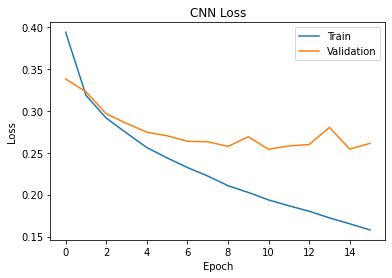

In [ ]:
model_performance_plot(cnn_hist.history, "loss", "val_loss","CNN Loss")

### BiLSTM with OneHotEncoding

In [ ]:
lstm_callbacks = [ReduceLROnPlateau(monitor='val_f1_metric', mode="max", patience=3, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=8, mode="min"),
             ModelCheckpoint(filepath='model/best_lstm.h5', monitor='val_f1_metric', mode="max", save_best_only=True)]

inputs = Input(shape=(maxlen,len_vocab))
l = Bidirectional(LSTM(64, return_sequences=True), backward_layer=LSTM(64, return_sequences=True, go_backwards=True))(inputs)
l = Dropout(0.3)(l)
l = Bidirectional(LSTM(32, return_sequences=True), backward_layer=LSTM(32, return_sequences=True, go_backwards=True))(l)
l = Dropout(0.3)(l)
l = Bidirectional(LSTM(32))(l)
l = Dropout(0.2)(l)
outputs = Dense(1, activity_regularizer=l2(0.05),activation="sigmoid")(l)
bilstm = Model(inputs, outputs)

opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
bilstm.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', f1_metric])
bilstm.summary()
bilstm_hist = bilstm.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, callbacks=lstm_callbacks)
scores = bilstm.evaluate(x_test, y_test)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 25, 27)]          0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 25, 128)          47104     
 nal)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 25, 128)           0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 25, 64)           41216     
 onal)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 25, 64)            0         
                                                                 
 bidirectional_11 (Bidirecti  (None, 64)               2483

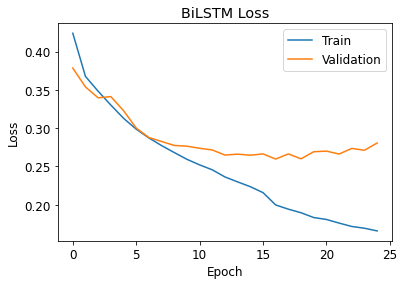

In [ ]:
model_performance_plot(bilstm_hist.history, "loss", "val_loss","BiLSTM Loss")

### BiLSTM with Char Embedding


In [ ]:
# input and embeddings for characters
lstm_callbacks = [ReduceLROnPlateau(monitor='val_f1_metric', mode="max", patience=3, verbose=1, factor=0.6),
             EarlyStopping(monitor='val_loss', patience=5, mode="min"),
             ModelCheckpoint(filepath='model/best_lstm_charEmb.h5', monitor='val_f1_metric', mode="max", save_best_only=True)]

inputs = Input(shape=(maxlen,))
emb_char = Embedding(input_dim=len_vocab, output_dim=15,input_length=1, mask_zero=True)(inputs) # 15 dimenions for each character in vocab
l = Bidirectional(LSTM(64, return_sequences=True), backward_layer=LSTM(64, return_sequences=True, go_backwards=True))(emb_char)
l = Dropout(0.3)(l)
l = Bidirectional(LSTM(32, return_sequences=True), backward_layer=LSTM(32, return_sequences=True, go_backwards=True))(l)
l = Dropout(0.3)(l)
l = Bidirectional(LSTM(32))(l)
l = Dropout(0.2)(l)
outputs = Dense(1, activity_regularizer=l2(0.05),activation="sigmoid")(l)
bilstm2 = Model(inputs, outputs)

opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
bilstm2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', f1_metric])
bilstm2.summary()
bilstm2_hist = bilstm2.fit(x_train2, y_train, validation_data=(x_val2, y_val), epochs=100, batch_size=32, callbacks=lstm_callbacks)
scores = bilstm2.evaluate(x_test2, y_test)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 25)]              0         
                                                                 
 embedding (Embedding)       (None, 25, 15)            405       
                                                                 
 bidirectional_3 (Bidirectio  (None, 25, 128)          40960     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 25, 128)           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 25, 64)           41216     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 25, 64)            0   

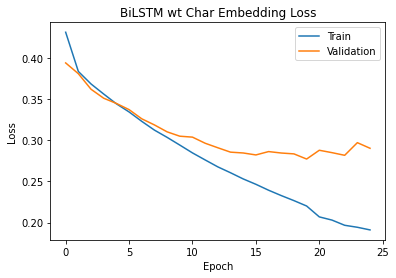

In [ ]:
model_performance_plot(bilstm2_hist.history, "loss", "val_loss","BiLSTM wt Char Embedding Loss")

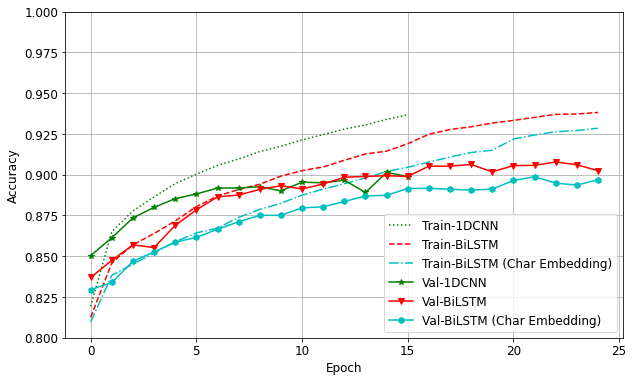

In [ ]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 12})
# summarize for accuracy
plt.plot(cnn_hist.history['accuracy'], 'g:')
plt.plot(bilstm_hist.history['accuracy'], 'r--')
plt.plot(bilstm2_hist.history['accuracy'], 'c-.')

plt.plot(cnn_hist.history['val_accuracy'], 'g-*')
plt.plot(bilstm_hist.history['val_accuracy'], 'r-v')
plt.plot(bilstm2_hist.history['val_accuracy'], 'c-h')

plt.grid('True')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.8, 1)
#plt.xlim(0,25)
plt.legend(['Train-1DCNN', 'Train-BiLSTM', 'Train-BiLSTM (Char Embedding)',
            'Val-1DCNN', 'Val-BiLSTM','Val-BiLSTM (Char Embedding)'], loc='lower right')
plt.savefig('dl_model_training_perf.png')
plt.show()

## Hyperparameter Tuning
From results above (e.g., validation accuracy), I select the BiLSTM model for hyperparameter tuning. Due to time limitions, the hyperparameter here would not be exhausive and may stuck at a local minimum in Bayseian optimization.

In [ ]:
# For hyperopt (parameter optimization)
# ! pip install hyperopt
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp
from hyperopt.pyll.base import scope #quniform returns float, some parameters require int; use this to force int
from tqdm.keras import TqdmCallback

In [ ]:
def tune_unit_bilstm(tune_params):
    """
    @params:
        tune_params: a dictionary of pre-defined hyper-parameters
    """
    lstm_callbacks = [ReduceLROnPlateau(monitor='val_f1_metric', mode="max", patience=3, verbose=1, factor=0.6),
                      EarlyStopping(monitor='val_loss', patience=8, mode="min")]

    inputs = Input(shape=(maxlen,len_vocab))
    l = Bidirectional(LSTM(tune_params["units"], return_sequences=True), backward_layer=LSTM(tune_params["units"], return_sequences=True, go_backwards=True))(inputs)
    l = Dropout(tune_params["dropout_rate"])(l)
    l = Bidirectional(LSTM(tune_params["units"]//2, return_sequences=True), backward_layer=LSTM(tune_params["units"]//2, return_sequences=True, go_backwards=True))(l)
    l = Dropout(tune_params["dropout_rate"])(l)
    l = Bidirectional(LSTM(tune_params["units"]//2))(l)
    l = Dropout(tune_params["dropout_rate"])(l)
    outputs = Dense(1, activity_regularizer=l2(0.05),activation="sigmoid")(l) # can put regularize factor as a hyper-parameter too
    bilstm = Model(inputs, outputs)
    opt = keras.optimizers.Adam(learning_rate=tune_params["lr"], beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    bilstm.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', f1_metric])
    result = bilstm.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, 
                        batch_size=tune_params["batch_size"], callbacks=[lstm_callbacks, TqdmCallback(verbose=0)])
    
    #get the lowest validation loss of the training epochs
    validation_loss = np.amin(result.history['val_loss']) 
    print('Best validation loss of epoch:', validation_loss)
    return {'loss': validation_loss, 'status': STATUS_OK, 'model': bilstm, 'params': tune_params}

In [ ]:
space = {'dropout_rate': hp.uniform('dropout_rate',0.01,0.5),
         'units'       : scope.int(hp.quniform('units',30,100,5)),
         'batch_size'  : scope.int(hp.quniform('batch_size',32,128,16)),
         'lr'      : hp.uniform('lr',0.001,0.01),
        }

In [ ]:
trials = Trials()
best = fmin(tune_unit_bilstm, space, algo=tpe.suggest, max_evals=10, trials=trials)

In [ ]:
best_model = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']
best_params = trials.results[np.argmin([r['loss'] for r in trials.results])]['params']
# the `best_model` is supposed to the final model.

Colab runs out of runtime during hyperparamter-tuning, hence I had to leave the code here without upgrading the lstm model with the tuned parameter and hence would use the lstm model as the "final" model.

## Final Model 

In [18]:
final_model = load_model('model/best_lstm.h5', custom_objects={"f1_metric": f1_metric})

In [19]:
nn_train_pred = final_model.predict(x_train,batch_size=32)
nn_val_pred = final_model.predict(x_val,batch_size=32)
nn_test_pred = final_model.predict(x_test,batch_size=32)

In [20]:
nn_train_pred_gender = (nn_train_pred>0.5).astype('int32').flatten()
nn_val_pred_gender = (nn_val_pred>0.5).astype('int32').flatten()
nn_test_pred_gender = (nn_test_pred>0.5).astype('int32').flatten()

In [21]:
accuracy_score(y_train, nn_train_pred_gender)

0.9481715338068929

In [22]:
accuracy_score(y_val, nn_val_pred_gender)

0.90778742436201

In [23]:
accuracy_score(y_test, nn_test_pred_gender)

0.9048671402262563

In [28]:
final_x = np.asarray(x_vec)

In [29]:
final_x.shape

(95025, 25, 27)

In [31]:
final_model.fit(final_x, y, epochs=3, batch_size=32)

Epoch 1/3
2970/2970 [==============================] - 54s 16ms/step - loss: 0.2072 - accuracy: 0.9242 - f1_metric: 0.8926
Epoch 2/3
2970/2970 [==============================] - 48s 16ms/step - loss: 0.2005 - accuracy: 0.9259 - f1_metric: 0.8943
Epoch 3/3
2970/2970 [==============================] - 47s 16ms/step - loss: 0.1940 - accuracy: 0.9292 - f1_metric: 0.8991


In [43]:
final_model.save("model/final_lstm.h5")

In [44]:
final_model_cp = load_model('model/final_lstm.h5', custom_objects={"f1_metric": f1_metric})

---